In [ ]:
# Tech-Conomy Project - 7313

In [2]:
# Setup - Importing Libraries

import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd 
import seaborn as sns 
import sklearn.metrics as metrics
import xgboost as xgb
import matplotlib.pyplot as plt
import calendar
import json  
import os

from sqlalchemy import create_engine, text
from gettext import install
from matplotlib.colors import ListedColormap
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# # Setup Continued - Connecting my python scritp to the databases

# # Details of the database connection

# I have removed the details for the connection 

# host = " "
# username = " "  
# password = " "  
# schema = " "

# # Creating a connection string using the fomrat replacing {} in the string with the respective inputs to the function
# connection_string ="mysql+pymysql://{}:{}@{}/{}".format(username, password, host, schema)

# # This creates a connection from the string we just created
# connection = create_engine(connection_string) # This is a part of the sqlalchemy library

# # SQL QUERIES, loading all four tables at in the same chunk here, but they are uploaded SEPARATELY

# # Blood Tests Query
# query_blood_tests = """
# SELECT*
# FROM BloodTests
# """

# # Otolaryngology Ophthalmolog Query
# query_otolaryngology_ophthalmology = """
# SELECT*
# FROM OtolaryngologyOphthalmology
# """

# # Main Query
# query_main = """
# SELECT*
# FROM Main
# """

# # Physiotherapy  Query
# query_physiotherapy = """ 
# SELECT* 
# FROM Physiotherapy """

# ####

# # Using the connection to run the SQL query and loading the data into a dataframe:
# df_blood_test = pd.read_sql_query(con=connection.connect(), sql=text(query_blood_tests))                                    # Blood Tests dataframe
# df_otolaryngology_ophthalmology = pd.read_sql_query(con=connection.connect(), sql=text(query_otolaryngology_ophthalmology)) # Otolaryngology Ophthalmolog dataframe
# df_main = pd.read_sql_query(con=connection.connect(), sql=text(query_main))                                                 # Main dataframe
# df_physiotherapy = pd.read_sql_query(con=connection.connect(), sql=text(query_physiotherapy))                               # Physiotherapy dataframe

In [4]:
# Setup Continued - Creating a dataframe with all databases

# df_main is merged with df_physiotherapy to create df 
df = pd.merge(df_main, df_physiotherapy, left_on='device_id', right_on='anonymous_mode_fingerprint', how='left')

# Pivot the DataFrame to have one row per customer with tests as columns
df_blood_test_pivoted = df_blood_test.pivot_table(
    index='session_id',     # Group by session_id
    columns='test',         # Create columns for each test
    values='result',        # Assuming the test values are in the column named results
    aggfunc='first'         # Keep the first value if duplicates exist
).reset_index()

# Merging df with pivoted df_blood_test
df = pd.merge(df, df_blood_test_pivoted, left_on='device_id', right_on='session_id', how='left')

# Merging df with unpickled_df_otolaryngology_ophthalmology to create the full and final df
df = pd.merge(df, df_otolaryngology_ophthalmology, left_on='device_id', right_on='cookie', how='left')

# Dropping the unnecessary ids 
df = df.drop(['anonymous_mode_fingerprint', 'session_id', 'cookie', 'ip_address'], axis = 1)

In [5]:
# Question 1 - Feature Engineering 

# Creating a function to group the zodiac signs into four elemental groups: fire, earth, air and water
def elemental_group_function(zodiac_sign):

    # Specifying which zodiac signs belong to which elemental group
    fire = ['Aries', 'Leo', 'Sagittarius'] 
    earth = ['Taurus', 'Virgo', 'Capricorn']
    air = ['Gemini', 'Libra', 'Aquarius']
    water  =['Cancer','Pisces', 'Scorpio']

    # If statments to allocate zodiac signs into the right group, mutally exclusive sets 
    if zodiac_sign in fire:
        return 'fire'
    if zodiac_sign in earth:
        return 'earth'
    if zodiac_sign in air:
        return 'air'
    if zodiac_sign in water: 
        return 'water'

# Applying the function that was created above 
df['elemental_group'] = df['zodiac_sign'].apply(elemental_group_function) 

# Imputation gender column

# Imputing missing values by assigning them 'man' since there were no 'women' in this dataset 
df['gender'] = df['gender'].fillna('man') # Assumption that this is a male dataset 

# Converting height in inches and feet to centimeters

# Function to convert height to centimeters
def height_to_cm_function(height):
    import re
    # Check if height is not a string (e.g. NaN) and handle it
    if not isinstance(height, str):
        return None  # Return None for missing  values

    # Use regex to extract feet and inches
    match = re.match(r"(\d+)ft\s*([\d.]+)?in", height)
    if match:
        feet = int(match.group(1))
        inches = float(match.group(2)) if match.group(2) else 0
        # Convert to centimeters
        return feet * 30.48 + inches * 2.54
    return None  # Handle invalid formats

# Apply the conversion function to the height_in_feet_inches column
df['height_in_centimeters'] = df['height_in_feet_inches'].apply(height_to_cm_function).round(1) # Rounding to one decimal place 
df = df.drop(['height_in_feet_inches'], axis = 1)                                               # Dropping the original height_in_feet_inches column

In [6]:
# Question 1 - Feature Engineering 

# Imputation for eyesight columns

# Assumption that there are missing values since the individual is satisfied with they eyesight and therefore eyesight correction is 0
df[['left_eye_sight_correction', 'right_eye_sight_correction']] = (df[['left_eye_sight_correction', 'right_eye_sight_correction']].fillna(0))

# Imputation for hearing status columns

# Assumption that there missing values since the individual is satisifed (own belief of normal) with they hearing, and therefore have not checked their hearing status 
df[['left_ear_hearing_status', 'right_ear_hearing_status']] = (df[['left_ear_hearing_status', 'right_ear_hearing_status']].fillna('NORMAL'))

# Imputation for Blood Values 

# Columns to clean, convert to numeric, and impute missing values
columns_to_process = [
    'Blood Glucose Level',
    'Blood Serum Creatinine',
    'Cholesterol (Total)',
    'Diastolic Blood Pressure',
    'Gamma Glutamyl Transferase',
    'Hemoglobin',
    'High Density Lipoprotein Cholesterol',
    'Low Density Lipoprotein Cholesterol',
    'Proteinuria',
    'Serum Glutamic Oxaloacetic Transaminase (ALT)',
    'Serum Glutamic Oxaloacetic Transaminase (AST)',
    'Systolic Blood Pressure',
    'Triglycerides Level'
]

# Process each column: convert to numeric and fill missing values with the median
for column in columns_to_process:
    df[column] = pd.to_numeric(df[column], errors='coerce')
    median_value = df[column].median(skipna=True)  # Calculate the median, skipping NaNs
    df[column].fillna(median_value, inplace=True)  # Fill missing values with median


# Imputation 'weight_in_kg', 'waistline_in_cm', 'bmi' and 'height_in_centimeters'
# To get some variation in the values I used iterative imputer

# Select columns for imputation of 'weight_in_kg', 'waistline_in_cm', 'bmi' and 'height_in_centimeters'
columns_to_impute = ['weight_in_kg', 'waistline_in_cm', 'bmi', 'height_in_centimeters'] 
additional_predictors = ['age'] 
columns_for_imputation = columns_to_impute + additional_predictors

imputation_df = df[columns_for_imputation]                               # Subset DataFrame for imputation

imputer = IterativeImputer(random_state=10)                              # Initialize the IterativeImputer

imputed_array = imputer.fit_transform(imputation_df)                     # Apply the imputer only on the selected columns

imputed_df = pd.DataFrame(imputed_array, columns=columns_for_imputation) # Convert the result back to a DataFrame

df[columns_to_impute] = imputed_df[columns_to_impute].round(1)           # Replace the imputed columns in the original DataFrame

# Imputation is_obese and is_severely_obese

# Imputing is_obese and is_severely_obese following criteria by https://obesitycanada.ca/managing-obesity/measuring-obesity/
df['is_obese'] = df['is_obese'].fillna(df['bmi'].apply(lambda bmi: 1 if 30 <= bmi < 40 else 0))              # Obesity 30 to 39.9
df['is_severely_obese'] = df['is_severely_obese'].fillna(df['bmi'].apply(lambda bmi: 1 if bmi >= 40 else 0)) # Severe obesity over 40

# Creating Blood Values by addition of Blood Glucose Level and Hemoglobin 
df['blood_values'] =  df['Blood Glucose Level'] + df['Hemoglobin'] # Will be dropped later, since this will only be used for the JSON FILE

/var/folders/dk/hpy2mtkd7sq6_2c3125100b80000gn/T/ipykernel_59153/1141172334.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)  # Fill missing values with median
/var/folders/dk/hpy2mtkd7sq6_2c3125100b80000gn/T/ipykernel_59153/1141172334.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [7]:
# Question 1 - Filtering for plot

# Filtering by age, as given in the instructions 
max_age = 70 # Max age allowed 
min_age = 34 # Min age allowed 
df_filtered = df[(df['age'] >= min_age) & (df['age'] <= max_age) ] # Applying the filter 

# Filtering to keep only the fire group
elemental_group_to_keep =  'fire' # Choosing element group to keep
df_filtered = df_filtered[(df_filtered['elemental_group'] == elemental_group_to_keep)] # Applying the filter 

avg_height = df_filtered['height_in_centimeters'].mean() # Calculating average height
df_filtered = df_filtered[(df_filtered['height_in_centimeters'] >= avg_height)] # Keeping everyone above or equal to the average height 

df_filtered = df_filtered[['age', 'Blood Glucose Level', 'Hemoglobin']] # Columns to plot 

# Exporting the df_filtered as an xlsx file and naming it df_filtered_to_plot because I will create the plot in excel
# I put it in hashtag so that the examiner does not get an excel file in their folder
# df_filtered.to_excel('df_filtered_to_plot.xlsx', index=False) 

In [8]:
# Question 2 - Feature Engineering

# Fixing the target variables 

# Define replacement values for smoker column
replacement_dict = {
    'Cigares do not kill people, people kill people': 'Smoker',
    'I CAN QUIT ANYTIME I WANT!': 'Smoker',
    'Cigarettes are my only friend': 'Smoker'}

# Apply the replacement to the column
df['smoker'] = df['smoker'].replace(replacement_dict)

# Define replacement values for drinker column
replacement_dict = {
    'Yes But Only Johnny Walker Black Label': 'Drinker',
    'uuhh... I only drink on weekends': 'Drinker'}

# Apply the replacement to the column
df['drinker'] = df['drinker'].replace(replacement_dict)

In [9]:
# Question 2 - Preparation for modelling 

# Sorting our df in descending order and putting NaNs first to make my life easier 
df = df.sort_values(by=['smoker', 'drinker'], ascending=False, na_position='first') 

# For JSON FILE and to keep track of the right index numbers
missing__count = df['drinker'].isna().sum()  # Works as long as drinker and smoker rows have the exactly the same missing values for the same index/row
df_json = df[['device_id', 'elemental_group', 'blood_values']].head(missing__count) # Extracting variables for the JSON file

# Dropping 'id' from the df that will be used for modelling and variables with zero signal (zero variation), blood_values since it was only for the classification set
df = df.drop(['device_id', 'gender', 'country', 'blood_values'], axis=1)

In [10]:
# Question 2 - Preparation for modelling 

# One Hot Encoding

# Specify the columns to one-hot encode
columns_to_encode = ['zodiac_sign', 'web_browser', 'state', 'elemental_group']   

df = pd.get_dummies(df, columns=columns_to_encode, dtype=int) # Perform one-hot encoding for only the specified columns

df['is_obese'] = df['is_obese'].astype('int64') # Converting to integers 

df['is_severely_obese'] = df['is_severely_obese'].astype('int64') # Converting to integers 

# These do not need to be encoded, but just converted to numeric
df['left_ear_hearing_status_normal'] = df['left_ear_hearing_status'].apply(lambda x: 1 if x == 'NORMAL' else 0) # 1 for normal and 0 for deviating 
df['right_ear_hearing_status_normal'] = df['left_ear_hearing_status'].apply(lambda x: 1 if x == 'NORMAL' else 0) # 1 for normal and 0 for deviating 
df = df.drop(['left_ear_hearing_status', 'right_ear_hearing_status'], axis = 1) # Dropping the old columns 

# Standarization
continuous_vars = (df.select_dtypes(include=['float64']).columns.tolist() + ['age']) # Detect float variables and including age which is an integer

df[continuous_vars] = StandardScaler().fit_transform(df[continuous_vars]) # Apply StandardScaler to the continuous variables detected 

# Numeric dummy encoding the target variables

# 1 if someone drinks, else 0, leaving NA values unchanged
df['drinker'] = df['drinker'].apply(lambda x: 1 if x == 'Drinker' else (0 if pd.notna(x) else x))

# 1 if someone smokes, else 0, leaving NA values unchanged
df['smoker'] = df['smoker'].apply(lambda x: 1 if x == 'Smoker' else (0 if pd.notna(x) else x))

In [11]:
# Question 2 - Preparation for modelling 

# Creating a df with no missing values for drinker and smoker columns
df_train_test = df[df['drinker'].notna()] # This works since smoker and drinker non missing value rows are matched

# Features for predicting drinker (and evenutally smokers aswell in Question 3)
X = df_train_test.drop(['drinker', 'smoker'], axis=1)  # Dropping smoker, not used for prediction due to missing values in the classification set

# Target
y_drinker = df_train_test[['drinker']] # Keeping only drinker column

# Splitting the data into training (90%) and testing (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y_drinker, test_size=0.1, random_state=10)

In [12]:
# Question 2 Modelling 

# Creating the XGBoost model and setting the hypertuned parameters
# The code for the hyperparamter tuning is in the Appendix of this ipynb file
xgboost_model = xgb.XGBClassifier(subsample = 1.0, n_estimators = 400, max_depth = 6, learning_rate = 0.05, colsample_bytree = 0.6, random_state = 10)  

# Fitting the model to the training data
xgboost_model.fit(X_train, y_train)  

# Predictions
y_train_pred = xgboost_model.predict(X_train)
y_test_pred = xgboost_model.predict(X_test)

# Evaluation 
train_accuracy = accuracy_score(y_train, y_train_pred) # Training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred) # Test accuracy

# Printing accuracies
print(round(train_accuracy, 4))  # Training accuracy rounded to four decimals 
print(round(test_accuracy, 4)) # Test accuracy rounded to four decimals

0.73
0.7242


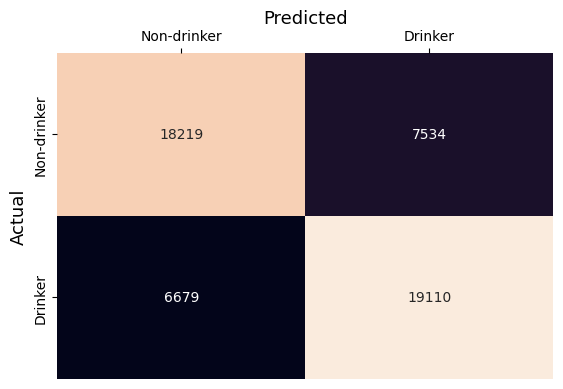

In [13]:
# Question 2 Confusion Matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred) 

# Plotting 
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g', 
            xticklabels=['Non-drinker','Drinker'],
            yticklabels=['Non-drinker','Drinker'],
            cbar = False)
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.gca().xaxis.set_label_position('top') 
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()


/var/folders/dk/hpy2mtkd7sq6_2c3125100b80000gn/T/ipykernel_59153/3083684755.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


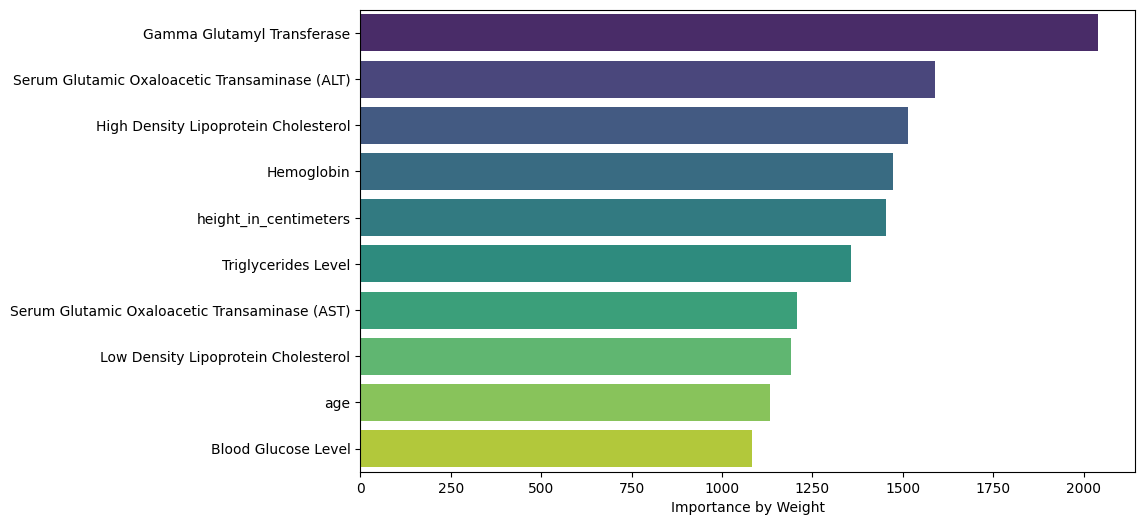

In [14]:
# Question 2 Feature Importance

# Get feature importances
feature_importance = xgboost_model.get_booster().get_score(importance_type='weight')

# Create DataFrame from the extracted importance
feature_importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),  # Feature names from the model
    'Importance': list(feature_importance.values())  # Importance scores
}).sort_values(by='Importance', ascending=False)

# Restrict to the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot feature importance with Seaborn for top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_10_features, 
    palette='viridis'
)
plt.xlabel('Importance by Weight')
plt.ylabel('')
plt.show()


In [15]:
# Question 2 Classification 

# Create a df where drinker and smokers columns only have missing values values, 10,000 rows 
df_classification = df[df['drinker'].isna()] 

# Features 
X = df_classification.drop(['drinker', 'smoker'], axis=1)  # Dropping smoker since it will not be used in prediction due to missing values

# Predicting the Drinker and Non-drinkers 
predicted_user_drinks = xgboost_model.predict(X)

# predicted_drinkers should have the same index as X
predicted_user_drinks = pd.DataFrame(predicted_user_drinks, index=X.index)

# Add the predictions to the df_json 
df_json['user_drinks'] = predicted_user_drinks

In [16]:
# Question 3 Preparation, Modelling and Evaluation

# Features smokers 
X = df_train_test.drop(['drinker', 'smoker'], axis=1) 
# I do not want to use the drinker predictions to predict smokers in case of the drinker predictions being very wrong 

# Target
y_smoker = df_train_test[['smoker']] # Keeping only the smoker column from df_train_test created in Question 2

# Splitting the data into training (90%) and testing (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y_smoker, test_size=0.1, random_state=10) 

# Target Variable is unbalanced, to address this issue I oversample the minority class in the TRAINING DATA ONLY
smote = SMOTE(random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

# Creating the XGBoost model and setting the same parameters as from the drinker modelling 
xgboost_model = xgb.XGBClassifier(subsample = 1.0, n_estimators = 400, max_depth = 6, learning_rate = 0.05, colsample_bytree = 0.6, random_state = 10)

# Fit the XGBoost model to the resampled data 
xgboost_model.fit(X_train_resampled, y_train_resampled) 

# Predictions
y_test_pred = xgboost_model.predict(X_test) 

# Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred) 
print(round(test_accuracy, 4)) # Test accuracy rounded to four decimals

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


0.799


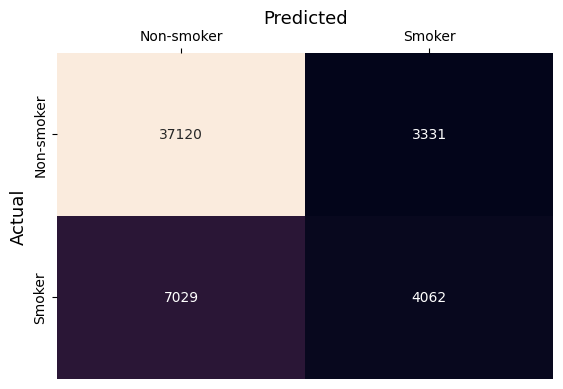

In [17]:
# Question 3 Confusion Matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred) 

# Plotting 
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g', 
            xticklabels=['Non-smoker','Smoker'],
            yticklabels=['Non-smoker','Smoker'],
            cbar = False)
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.gca().xaxis.set_label_position('top') 
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

In [18]:
# Question 3 Classification   

# Features 
X = df_classification.drop(['drinker', 'smoker'], axis=1) 

# Predicting the smokers and non-smokers 
predicted_user_smokes = xgboost_model.predict(X)

# predicted_drinkers should have the same index as classification_df
predicted_user_smokes = pd.DataFrame(predicted_user_smokes, index=X.index)

# Add the predictions to the df_json
df_json['user_smokes'] = predicted_user_smokes

In [19]:
# Question 3 Persona Classification   

# Creating a function to be able classify a persona 
def persona_classification_function(user_smokes, user_drinks):

    # If user neither drinks or smokes then he is a 'Saint'
    if user_smokes == 0 and user_drinks == 0:
        return 'Saint'

    # If user smokes, but does not drink then he is a 'Fumer'
    if user_smokes == 1 and user_drinks == 0:
        return 'Fumer'
    
    # If user does not smoke, but drinks then he is a 'Fumer'
    if user_smokes == 0 and user_drinks == 1:
        return 'Tippler'
    
    # If user drinks and smokes then he is a 'Sinner'
    if user_smokes == 1 and user_drinks == 1:
        return 'Sinner'
    
# Applying the function row by row to the classification_df
df_json['persona'] = df_json.apply(lambda row: persona_classification_function(row["user_smokes"], row["user_drinks"]), axis = 1)

In [20]:
# Question 3 Company-Persona Allocation and Profit Maximization 

# Shares from Confusion Matrices 
# Assuming that the shares from the confusion matrices are the same as for the predictions 

# Store confusion 'matrices' values in a dictionary
# a_mn for drinkers for numbering (e.g., a_11 is in the first row and first column)
matrices = {
    "drinker": {"a_11": 18179, "a_12": 7574,
                "a_21": 6723, "a_22": 19066},
    "smoker": { "a_11": 37178,"a_12": 3273,
               "a_21": 7089, "a_22": 4002}}

# Calculate shares

# From Drinker Confusion Matrix 
true_non_drinker_share = matrices['drinker']['a_11'] /  (matrices['drinker']['a_11'] + matrices['drinker']['a_21']) # Predicted non-drinker and actual non-drinker
false_non_drinker_share = matrices['drinker']['a_21'] /  (matrices['drinker']['a_11'] + matrices['drinker']['a_21']) # Predicted non-drinker but actual drinker

false_drinker_share = matrices['drinker']['a_12'] /  (matrices['drinker']['a_12'] + matrices['drinker']['a_22']) # Predicted drinker, but actual non-drinker
true_drinker_share = matrices['drinker']['a_22'] /  (matrices['drinker']['a_12'] + matrices['drinker']['a_22']) # Predicted drinker and actual drinker

# From Smooker Confusion Matrix 
true_non_smoker_share = matrices['smoker']['a_11'] /  (matrices['smoker']['a_11'] + matrices['smoker']['a_21']) # Predicted non-smoker and actual non-smoker
false_non_smoker_share = matrices['smoker']['a_21'] /  (matrices['drinker']['a_11'] + matrices['smoker']['a_21']) # Predicted non-smoker but actual smoker

false_smoker_share = matrices['smoker']['a_12'] /  (matrices['smoker']['a_12'] + matrices['smoker']['a_22']) # Predicted smoker, but actual non-smoker
true_smoker_share = matrices['smoker']['a_22'] /  (matrices['smoker']['a_12'] + matrices['smoker']['a_22']) # Predicted smoker and actual smoker

# Available counts of each persona
persona_counts = df_json['persona'].value_counts() # Counting amount of values for each persona
persona_counts_dict = persona_counts.to_dict() # Converting to a dict
print(persona_counts_dict) # Priting the dictionary created 

# Defining the Price Nested Dictionaries with prices given in the instruction
prices_dict = {
    "johnny_talker_prices": {'saint': -14, 'sinner': 22, 'fumer': -13, 'tippler': 10},
    "rate_race_prices": {'saint': 12, 'sinner': -21, 'fumer': -5, 'tippler': -5},
    "spin_win_prices": {'saint': -0.5, 'sinner': 0.21, 'fumer': 0.14, 'tippler': 0.09}
    }

{'Saint': 4794, 'Tippler': 3788, 'Sinner': 1391, 'Fumer': 27}


In [21]:
# Question 3.1 Johnny Talker

# Calculating expected profits per type  with this formula E[x] = x * P(x) + y * (1 - P(x))

# Expected profit for a sinner 
profit_per_sinner = (true_drinker_share * prices_dict['johnny_talker_prices']['sinner']) + (false_drinker_share * prices_dict['johnny_talker_prices']['fumer']) 

# Expected profit for a tippler
profit_per_tippler = (true_drinker_share * prices_dict['johnny_talker_prices']['tippler']) + (false_drinker_share * prices_dict['johnny_talker_prices']['saint'])

# Expected profit for a saint 
profit_per_saint = (true_non_drinker_share * prices_dict['johnny_talker_prices']['saint']) + (false_non_drinker_share * prices_dict['johnny_talker_prices']['tippler'])

# Expected profit for a saint 
profit_per_fumer = (true_non_drinker_share * prices_dict['johnny_talker_prices']['fumer']) + (false_non_drinker_share * prices_dict['johnny_talker_prices']['sinner']) 

# Expected profit for a sinner and tippler are positive, thus we include them 
df_json['johnny_talker'] = df_json['persona'].apply(lambda x: 1 if x in ['Sinner', 'Tippler'] else 0)

# Calculating the Expected Total Profit 
expected_total_proft_sinners = ((persona_counts_dict.get('Sinner') * true_drinker_share * prices_dict['johnny_talker_prices']['sinner']) + 
                       (persona_counts_dict.get('Fumer') * false_drinker_share * prices_dict['johnny_talker_prices']['fumer']))

expected__total_proft_tipplers = ((persona_counts_dict.get('Tippler') * true_drinker_share * prices_dict['johnny_talker_prices']['tippler']) + 
                      (persona_counts_dict.get('Saint') * false_drinker_share * prices_dict['johnny_talker_prices']['saint']))

expected_total_profit = expected_total_proft_sinners + expected__total_proft_tipplers
print(expected_total_profit)

29830.433708708704


In [22]:
# Question 3.2 Rat Race Ltd

# Expected profit for a saint with a probabilistic modeling taking into account dual probabilites 
profit_per_saint= ((true_non_smoker_share * true_non_drinker_share  * prices_dict['rate_race_prices']['saint']) + 
                   (false_smoker_share * false_drinker_share * prices_dict['rate_race_prices']['saint'])) 

# Expected profit for a Saint is positive, thus we include all of them  
df_json['rat_race'] = df_json['persona'].apply(lambda x: 1 if x in ['Saint'] else 0)

# Calculating the expected_total_profit for a Saint 
expected_total_profit = profit_per_saint * persona_counts_dict.get('Saint')
print(expected_total_profit)

42629.65909314888


In [ ]:
# Question 3.3 Spin2Win

# Specifying which users were sold to rat_race
df_json['spin_win'] = df_json['persona'].apply(lambda x: 1 if x in ['Sinner', 'Fumer', 'Tippler'] else 0)

# Calculating the totalt profit of selling to Sinner, Fumer and Tippler following the instruction
exponent = 1.2 
expected_total_profit = (pow(prices_dict['spin_win_prices']['sinner'] * 0.5 * persona_counts_dict.get('Sinner'), exponent) + 
                         pow(prices_dict['spin_win_prices']['fumer'] * 0.5 * persona_counts_dict.get('Fumer'), exponent) + 
                         pow(prices_dict['spin_win_prices']['tippler'] * 0.5 * persona_counts_dict.get('Tippler'), exponent)) 

print(expected_total_profit)

874.2683408582935


In [ ]:
# JSON 
df_json = df_json.drop(['user_smokes', 'persona'], axis =1) # Dropping variables that should not be included 

# Here we convert the cleaned dataframe to a list of dictionaries:
list_of_dictionaries = df_json.to_dict(orient='records')

# Writing the list of dictionaries to a JSON file with my assigned file name:
with open('Tech-Conomy-Project.json', 'w') as file:
    json.dump(list_of_dictionaries, file, indent=2)

                                                device_id elemental_group  \
6       0000da58db9a7f45ca92a0c5b7561d1add9453d5e08c4b...           water   
102     000cdbcd7777f810e4b4d85fe6226b3ac96059c83eaad7...             air   
151     001185ba22d7497f3ef147145c0d8f300fa5af87f76587...           earth   
201     0017b3296d2b85b12e4f72abf7925b40c70c70d5dc9e7d...           earth   
204     001817a0e2d0ab4c3831e4d2d8d6000f6710da00f63fe1...            fire   
...                                                   ...             ...   
525293  fff0a2aca8df9f667324d36a9cf056bb0c9f3ec35eb235...            fire   
525302  fff20f0d130e70a80441488f617cc024fe45afd1a0cfe2...           earth   
525304  fff23ec219b8f7d7459f0c47740b9b91510f0e9fcd7d22...           water   
525389  fffd425bb13be13f3ba0d91cfa1aded56d5a6845a06588...           earth   
525399  fffe7d7469f9c1a3cef3c013c11d886ff132652537d5c0...           earth   

        blood_values  user_drinks  johnny_talker  rat_race  spin_win  
6   

In [25]:
# Appendix A

# # Question 1 - Feature Engineering 

# # Correlation Matrix for numeric features only 
# numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
# correlation_matrix = df[numeric_columns].corr()

# # Correlation matrix
# plt.figure(figsize=(8, 8))  
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# # Labels and title
# plt.title("Correlation Matrix of Numerical Features", fontsize=10, pad=10)
# plt.xticks(rotation=40, ha='right', fontsize=8)
# plt.yticks(fontsize=8)
# plt.tight_layout()
# plt.show()
# print(df)

In [26]:
# Appendix B

# Question 2 - Hyperparameter tuning

# # Define a simple parameter grid
# param_grid = {
#    'max_depth': [4, 5, 6, 8],
#    'subsample': [0.6, 0.8, 1.0],
#    'colsample_bytree': [0.6, 0.8, 1.0],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'n_estimators': [100, 200, 400, 600]}


# # Initialize the XGBRegressor with a fixed random state
# xgb_base = xgb.XGBClassifier(random_state=10)

# # Perform RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=xgb_base,
#     param_distributions=param_grid,
#     n_iter=20,  # Number of parameter combinations to try
#     scoring='accuracy',  # Evaluation metric
#     cv=3,  # 3-fold cross-validation
#     verbose=1,  # Verbosity level
#     random_state=10,  # Ensures reproducibility
#     n_jobs=-1  # Use all available processors
# )

# # Fit RandomizedSearchCV to the training data
# random_search.fit(X_train, y_train)

# # Retrieve the best parameters and train the final model
# print("Best Parameters:", random_search.best_params_)

# # Train the model with the best parameters
# best_xgb_model = random_search.best_estimator_

# # Predictions
# y_train_pred = best_xgb_model.predict(X_train)
# y_test_pred = best_xgb_model.predict(X_test)

# #  Evaluate the model using accuracy_score
# train = accuracy_score(y_train, y_train_pred)
# test = accuracy_score(y_test, y_test_pred)

# # Print accuracy_score results                            
# print(f"Training: {round(train, 4)}")
# print(f"Testing: {round(test, 4)}")

In [27]:
# Appendix C

# # Question 2 Modelling 

# # Logistic Regression
# # Creating the logistic regression model with parameters
# logistic_regression_model = LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 100, class_weight = 'balanced', C = 0.01)

# logistic_regression_model.fit(X_train, y_train) # Fitting the model to the training data

# # Predictions
# y_train_pred = logistic_regression_model.predict(X_train)
# y_test_pred = logistic_regression_model.predict(X_test)

# # Evaluation 
# train_accuracy = accuracy_score(y_train, y_train_pred) # Training accuracy
# test_accuracy = accuracy_score(y_test, y_test_pred) # Test accuracy

# # Printing accuracies
# print(round(train_accuracy, 4))  # Training accuracy rounded to four decimals 
# print(round(test_accuracy, 4)) # Test accuracy rounded to four decimals

In [28]:
# # Appendix D

# # Define a simple parameter grid
# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization types
#     'C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
#     'solver': ['liblinear', 'saga'],       # Suitable solvers
#     'class_weight': [None, 'balanced'],    # Handle imbalance
#     'max_iter': [100, 200, 500]            # Convergence criteria
# }

# # Initialize the logistic regression model
# logreg = LogisticRegression(random_state=10)

# # Perform RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=logreg,
#     param_distributions=param_grid,
#     n_iter=20,  # Number of parameter combinations to try
#     scoring='accuracy',  # Evaluation metric
#     cv=3,  # 3-fold cross-validation
#     verbose=1,  # Verbosity level
#     random_state=10,  # Ensures reproducibility
#     n_jobs=-1  # Use all available processors
# )

# # RandomizedSearchCV to the training data
# random_search.fit(X_train, y_train)

# # Retrieve the best parameters and train the final model
# print("Best Parameters:", random_search.best_params_)

# # Train the model with the best parameters
# best_logreg = random_search.best_estimator_

# # Step 6: Predictions
# y_train_pred = best_logreg.predict(X_train)
# y_test_pred = best_logreg.predict(X_test)

# # Step 7: Evaluate the model using accuracy_score
# train = accuracy_score(y_train, y_train_pred)
# test = accuracy_score(y_test, y_test_pred)

# # Print results                            
# print(f"Training: {round(train, 4)}")
# print(f"Testing: {round(test, 4)}")